In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from glob import glob
import SimpleITK as sitk
import tensorflow as tf
from tensorflow import keras
from keras.layers import AveragePooling3D
import time
import copy
from sklearn.cluster import KMeans
import pandas as pd
import gc
from sklearn.linear_model import LinearRegression
import math
import tensorflow as tf
from multiprocessing import Process, Manager
import datetime
import sys
import csv
import os
from tensorflow.keras.utils import to_categorical
from data_generate import *  # 参数生成文件
from KEM_SIMU import *  # KEM 类
sys.path.append('../')
sys.path.append('../Models/')
from utils import *
from GMM import *
from Kmeans import *


%matplotlib inline

In [2]:
num_gpu = 1
gpu_name = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_name}"

In [3]:
K = 3

# 数据的路径
lung_image_path = "/database/datasets/Classics/LUNA2016/IMAGES/"  # 存放CT的文件夹
lung_mask_path = "/database/datasets/Classics/LUNA16-Mask/"  # 存放肺部mask的文件夹

# the absolute paths of the CT files
lung_image_file_list = glob(lung_image_path + "*.mhd")

stats_dict = {'lung_image_path': lung_image_path,
              'lung_mask_path': lung_mask_path,
              'lung_image_file_list': lung_image_file_list,
              }

# Bandwidth Selection

- choose kernel sizes and bandwidth candidates for CV and REG methods

- coefficients for CV: [0.5, 0.9, 1.3, 1.7, 2.1]

In [4]:
#     for coef in np.arange(start=0.5, stop=2.5, step=2/5):

In [5]:
kernel_size_list = np.arange(3, 12, 2)
coef_list = [0.3, 0.4, 0.5, 0.6, 0.7]

# CV: kernel size list and bandwidth candidate list
CV_kernel_size_list = []
CV_bandwidth_list = []
CV_coef_list = []
# i = 0
for kernel_size in kernel_size_list:
    for coef in coef_list:
        CV_kernel_size_list.append(kernel_size)
        CV_bandwidth_list.append(kernel_size / 512 * coef)
        CV_coef_list.append(coef)
#         print(f"[{i}]: kernel size: {kernel_size}; coef: {coef:.4f}; bwd: {kernel_size / 512 * coef:.4f}")
#         i += 1

In [6]:
# REG: kernel size list and bandwidth candidate list
REG_kernel_size_list = []
REG_bandwidth_list = []
for kernel_size in kernel_size_list:
    for coef in [1]:
        REG_kernel_size_list.append(kernel_size)
        REG_bandwidth_list.append(kernel_size / 512 * coef)

print(f"length of CV candidates: {len(CV_kernel_size_list)}")
print(f"length of REG candidates: {len(REG_kernel_size_list)}")

# save to stats_dict
stats_dict['CV_kernel_size_list'] = CV_kernel_size_list
stats_dict['CV_bandwidth_list'] = CV_bandwidth_list
stats_dict['CV_coef_list'] = CV_coef_list
stats_dict['REG_kernel_size_list'] = REG_kernel_size_list
stats_dict['REG_bandwidth_list'] = REG_bandwidth_list

length of CV candidates: 25
length of REG candidates: 5


In [7]:
# the path to record the Ch information
# Ch_path = f"./【results】/Ch-{datetime.date.today().isoformat()}.csv"
Ch_path = f"./【results】/Ch-2023-10-31.csv"

# with open(Ch_path, 'w', newline='', encoding='utf-8') as f:
#     csv_write = csv.writer(f)  
#     csv_write.writerow([f"patient", "data_gen_time", 
#                         "Ch_CV", "i_CV", "kernel_size_CV", "coef_CV", "time_CV", 
#                         "Ch_REG", "time_REG", "model.coef0", "model.coef1"])

In [8]:
# randomly select 100 patients for bandwidth selection
np.random.seed(0)
index_list = np.arange(0, len(lung_image_file_list), 1)
np.random.shuffle(index_list)

In [9]:
index_list = index_list[:100]

# transform the dict so that it can be used in the following Process
manager = Manager()
stats_dict = manager.dict(stats_dict)

In [10]:
idx_increase = int(len(index_list) / num_gpu)
i = gpu_name
idx_start = i * idx_increase
idx_end = (i + 1) * idx_increase

if i == num_gpu - 1:
    idx_end = len(index_list)
print(f"GPU{gpu_name} with index list: [{idx_start}:{idx_end}]")
gpu_index_list = index_list[idx_start:idx_end]

GPU0 with index list: [0:100]


In [14]:
for index in index_list:
    np.random.seed(index)
    tf.random.set_seed(index)
    stats_dict['index'] = index
    process_eval = Process(target=compute_Ch_4_cv_reg, 
                           args=(stats_dict, Ch_path, 0.8))
    process_eval.start()
    process_eval.join()

index[150]: continue
index[406]: continue
index[513]: continue
index[101]: continue
---------------WE ARE LOADING 584th PATIENT's CT with shape (383, 512, 512)---------------


2023-11-02 01:20:30.322329: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 01:20:31.839773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 01:20:35.381062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4085]; Class lung[0.0556]
##########[584]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.812 seconds
	centers: [9.9827415e-01 4.0010285e-01 4.2773542e-04]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 383, 512, 512, 1)
	pi_estimate: (3, 383, 512, 512, 1)
	mu_estimate: (3, 383, 512, 512, 1)
	sigma_estimate: (3, 383, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221028
From function(kem_algorithm): E step success.
	 Current pi difference: 0.03750

2023-11-02 01:40:17.712780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 01:40:18.995321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 01:40:22.912845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6094]; Class lung[0.3632]
##########[701]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.698 seconds
	centers: [1.0025358  0.60714203 0.20495851]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 375, 512, 512, 1)
	pi_estimate: (3, 375, 512, 512, 1)
	mu_estimate: (3, 375, 512, 512, 1)
	sigma_estimate: (3, 375, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.219577
From function(kem_algorithm): E step success.
	 Current pi difference: 0.038361
	 Curre

2023-11-02 02:09:35.521109: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 02:09:36.542932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 02:09:40.803195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7410]; Class lung[0.4436]
##########[395]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.066 seconds
	centers: [1.0178379 0.7476071 0.3380546]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 461, 512, 512, 1)
	pi_estimate: (3, 461, 512, 512, 1)
	mu_estimate: (3, 461, 512, 512, 1)
	sigma_estimate: (3, 461, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.215555
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma_es

2023-11-02 02:59:21.027241: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 02:59:22.074776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 02:59:25.992054: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5138]; Class lung[0.0496]
##########[196]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.824 seconds
	centers: [0.99677664 0.49589717 0.04323762]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 425, 512, 512, 1)
	pi_estimate: (3, 425, 512, 512, 1)
	mu_estimate: (3, 425, 512, 512, 1)
	sigma_estimate: (3, 425, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221225
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0376958
	 Curr

2023-11-02 03:17:11.735310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 03:17:14.834616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 03:17:21.201736: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4469]; Class lung[0.0468]
##########[299]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.988 seconds
	centers: [0.9984044  0.43739176 0.03867837]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 429, 512, 512, 1)
	pi_estimate: (3, 429, 512, 512, 1)
	mu_estimate: (3, 429, 512, 512, 1)
	sigma_estimate: (3, 429, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221025
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0376989
	 Curr

2023-11-02 03:40:05.480089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 03:40:08.561183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 03:40:14.742609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4235]; Class lung[0.0402]
##########[55]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.847 seconds
	centers: [0.9975016  0.41339204 0.01769788]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 411, 512, 512, 1)
	pi_estimate: (3, 411, 512, 512, 1)
	mu_estimate: (3, 411, 512, 512, 1)
	sigma_estimate: (3, 411, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220645
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0379502
	 Curre

2023-11-02 04:02:44.135310: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 04:02:46.900156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 04:02:53.184199: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5969]; Class lung[0.3646]
##########[771]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.985 seconds
	centers: [1.0024312  0.5976918  0.19342068]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 445, 512, 512, 1)
	pi_estimate: (3, 445, 512, 512, 1)
	mu_estimate: (3, 445, 512, 512, 1)
	sigma_estimate: (3, 445, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.219829
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma

2023-11-02 04:37:52.166093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 04:37:55.071196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 04:38:01.335887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4259]; Class lung[0.0604]
##########[781]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.011 seconds
	centers: [0.9979569  0.41711906 0.01938423]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 371, 512, 512, 1)
	pi_estimate: (3, 371, 512, 512, 1)
	mu_estimate: (3, 371, 512, 512, 1)
	sigma_estimate: (3, 371, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220952
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0375825
	 Curr

2023-11-02 04:58:10.857647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 04:58:13.470145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 04:58:20.457919: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7237]; Class lung[0.4257]
##########[215]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.0125 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.808 seconds
	centers: [1.0152165 0.7298753 0.3207898]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 541, 512, 512, 1)
	pi_estimate: (3, 541, 512, 512, 1)
	mu_estimate: (3, 541, 512, 512, 1)
	sigma_estimate: (3, 541, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.216421
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0416637
	 Current 

2023-11-02 05:55:17.245386: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 05:55:18.262430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 05:55:21.092272: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4083]; Class lung[0.0589]
##########[306]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.638 seconds
	centers: [0.9979979  0.39864734 0.0021466 ]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 392, 512, 512, 1)
	pi_estimate: (3, 392, 512, 512, 1)
	mu_estimate: (3, 392, 512, 512, 1)
	sigma_estimate: (3, 392, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220733
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0378845
	 Curr

2023-11-02 06:15:58.360723: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 06:15:59.386207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 06:16:02.305955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4878]; Class lung[0.0575]
##########[520]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.732 seconds
	centers: [0.9982176  0.4761574  0.04954644]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 421, 512, 512, 1)
	pi_estimate: (3, 421, 512, 512, 1)
	mu_estimate: (3, 421, 512, 512, 1)
	sigma_estimate: (3, 421, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221259
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0377608
	 Curr

2023-11-02 06:37:45.065850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 06:37:46.119671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 06:37:49.528766: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7103]; Class lung[0.4188]
##########[671]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.111 seconds
	centers: [1.0135485  0.71653545 0.30758664]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 474, 512, 512, 1)
	pi_estimate: (3, 474, 512, 512, 1)
	mu_estimate: (3, 474, 512, 512, 1)
	sigma_estimate: (3, 474, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.217134
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma

2023-11-02 07:25:32.549034: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 07:25:33.574226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 07:25:36.949200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6000]; Class lung[0.3765]
##########[372]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.73 seconds
	centers: [1.0026609 0.6019215 0.1972016]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 417, 512, 512, 1)
	pi_estimate: (3, 417, 512, 512, 1)
	mu_estimate: (3, 417, 512, 512, 1)
	sigma_estimate: (3, 417, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.21977
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma_esti

2023-11-02 07:58:08.359290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 07:58:09.656147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 07:58:13.080742: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7590]; Class lung[0.4572]
##########[283]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.479 seconds
	centers: [1.0189502  0.76245415 0.35529268]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 513, 512, 512, 1)
	pi_estimate: (3, 513, 512, 512, 1)
	mu_estimate: (3, 513, 512, 512, 1)
	sigma_estimate: (3, 513, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.215027
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma

2023-11-02 08:53:53.283610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 08:53:54.233517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 08:53:56.876007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4040]; Class lung[0.0753]
##########[202]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.372 seconds
	centers: [ 0.99893296  0.3976487  -0.00330688]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 368, 512, 512, 1)
	pi_estimate: (3, 368, 512, 512, 1)
	mu_estimate: (3, 368, 512, 512, 1)
	sigma_estimate: (3, 368, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.22114
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0375071
	 Cu

2023-11-02 09:13:41.538336: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 09:13:42.450653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 09:13:45.539551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5920]; Class lung[0.0589]
##########[317]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.698 seconds
	centers: [1.0008585  0.58029854 0.05280127]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 419, 512, 512, 1)
	pi_estimate: (3, 419, 512, 512, 1)
	mu_estimate: (3, 419, 512, 512, 1)
	sigma_estimate: (3, 419, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.22038
From function(kem_algorithm): E step success.
	 Current pi difference: 0.038652
	 Curren

2023-11-02 09:38:16.728669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 09:38:19.511878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 09:38:24.604587: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6136]; Class lung[0.3577]
##########[743]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.956 seconds
	centers: [1.0032812  0.6138058  0.21082184]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 445, 512, 512, 1)
	pi_estimate: (3, 445, 512, 512, 1)
	mu_estimate: (3, 445, 512, 512, 1)
	sigma_estimate: (3, 445, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.219463
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma

2023-11-02 10:14:07.960590: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:14:12.803125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:14:21.104018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5370]; Class lung[0.0608]
##########[825]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01249 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.44 seconds
	centers: [0.9968249  0.5130603  0.04961961]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 338, 512, 512, 1)
	pi_estimate: (3, 338, 512, 512, 1)
	mu_estimate: (3, 338, 512, 512, 1)
	sigma_estimate: (3, 338, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220771
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0381516
	 Curre

2023-11-02 10:28:42.953037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:28:44.008799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:28:47.585773: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4149]; Class lung[0.0410]
##########[674]########## The 0th bandwidth from REG ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01249 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.594 seconds
	centers: [0.99780697 0.40507996 0.00698666]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 337, 512, 512, 1)
	pi_estimate: (3, 337, 512, 512, 1)
	mu_estimate: (3, 337, 512, 512, 1)
	sigma_estimate: (3, 337, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220929
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0375934
	 Curr

## Comparison on randonly selected CT

【Metrics】
- RMSE (with training position ratio=1)
    - $\pi$
    - $\mu$
    - $\sigma$
- Test ACC (with training position ratio=0.8)

【Methods】

- KEM (under personal optimal bandwidth):
    - CV
    - REG
- Kmeans
- GMM

### KEM

In [14]:
to_csv_path = f"./【results】/compare_metrics_KEM-2023-11-01.csv"

# with open(to_csv_path, 'w', newline = '', encoding='utf-8') as f:
#     csv_write = csv.writer(f)  
#     csv_write.writerow(["patient", "CV_SPE", "REG_SPE", 
#                         "patient_again", "CV_pi_rmse", "CV_mu_rmse", "CV_sigma_rmse", 
#                         "REG_pi_rmse", "REG_mu_rmse", "REG_sigma_rmse"])

In [15]:
# read the information of the randomly selected CT
random_info = pd.read_csv("./【results】/random100_info.csv")
print(random_info.shape)
random_info.head()

(100, 2)


,patient,depth
0,patient_150,292
1,patient_406,147
2,patient_513,110
3,patient_101,197
4,patient_584,383


In [16]:
# results at hand
Ch_df = pd.read_csv(Ch_path)
Ch_df = Ch_df.drop_duplicates(subset=["patient"], keep="first")
Ch_df.shape

(100, 11)

In [17]:
# merge results; no NaN exists
random_merge = pd.merge(random_info, Ch_df, how="left", on="patient")
random_merge.head()

,patient,depth,data_gen_time,Ch_CV,i_CV,kernel_size_CV,coef_CV,time_CV,Ch_REG,time_REG,model.coef0,model.coef1
0,patient_150,292,14.683044,0.111331,21.0,11.0,0.4,1456.803695,0.233042,401.203525,0.111005,0.000001
1,patient_406,147,14.988572,0.151400,23.0,11.0,0.6,613.941478,0.214797,149.646546,0.332126,0.000002
2,patient_513,110,11.642171,0.145258,23.0,11.0,0.6,760.700288,0.198921,182.091885,0.376583,0.000002
3,patient_101,197,20.568400,0.131556,22.0,11.0,0.5,784.775665,0.226474,197.654760,0.238026,0.000002
4,patient_584,383,25.538676,0.115730,21.0,11.0,0.4,860.322708,0.249160,300.563646,0.206875,0.000004


In [18]:
exist_csv = pd.read_csv(to_csv_path)
exist_csv.head()

,patient,CV_ACC,REG_ACC,patient_again,CV_pi_rmse,CV_mu_rmse,CV_sigma_rmse,REG_pi_rmse,REG_mu_rmse,REG_sigma_rmse
0,patiant_406,0.997154,0.997626,patient_406,0.043023,0.017958,0.011141,0.024777,0.015328,0.007906
1,patiant_513,0.995498,0.998478,patient_513,0.047563,0.022848,0.017308,0.032175,0.019169,0.016600
2,patiant_484,0.983717,0.984174,patient_484,0.045145,0.023355,0.012710,0.029870,0.020742,0.008200
3,patiant_855,0.998253,0.999175,patient_855,0.044722,0.017352,0.014414,0.029697,0.012896,0.011296
4,patiant_465,0.994197,0.994150,patient_465,0.044615,0.021676,0.012913,0.028928,0.022079,0.012161


In [19]:
exist_list = exist_csv.patient.apply(lambda x: int(x.split("_")[1]))
exist_list = list(exist_list)
Ch_list = list(Ch_df.patient.apply(lambda x: int(x.split("_")[1])))
print(len(exist_list))
print(exist_list)
print(len(Ch_list))
print(Ch_list)

100
[406, 513, 484, 855, 465, 643, 285, 60, 686, 14, 267, 145, 344, 474, 874, 878, 432, 663, 308, 181, 337, 318, 630, 97, 304, 837, 538, 627, 8, 144, 483, 270, 363, 30, 783, 293, 807, 526, 759, 527, 706, 569, 587, 764, 236, 788, 382, 687, 583, 475, 761, 204, 384, 506, 271, 101, 31, 391, 815, 833, 390, 77, 667, 735, 757, 640, 649, 279, 693, 810, 230, 266, 301, 34, 669, 765, 27, 721, 150, 631, 770, 584, 701, 395, 196, 299, 55, 771, 781, 215, 306, 520, 671, 372, 283, 202, 317, 743, 825, 674]
100
[406, 513, 101, 31, 484, 855, 465, 643, 285, 60, 686, 14, 267, 145, 344, 474, 874, 878, 432, 663, 308, 181, 337, 318, 630, 97, 304, 837, 538, 627, 8, 144, 483, 270, 363, 391, 30, 783, 293, 807, 526, 759, 527, 706, 569, 587, 764, 236, 788, 382, 687, 583, 475, 761, 204, 384, 506, 271, 150, 815, 833, 390, 77, 667, 735, 757, 640, 649, 279, 631, 693, 810, 230, 266, 301, 34, 770, 669, 765, 27, 721, 584, 701, 395, 196, 299, 55, 771, 781, 215, 306, 520, 671, 372, 283, 202, 317, 743, 825, 674]


In [20]:
data_index = random_merge.query(f'patient == "patient_{150}"')
data_index

,patient,depth,data_gen_time,Ch_CV,i_CV,kernel_size_CV,coef_CV,time_CV,Ch_REG,time_REG,model.coef0,model.coef1
0,patient_150,292,14.683044,0.111331,21.0,11.0,0.4,1456.803695,0.233042,401.203525,0.111005,0.000001


In [ ]:
for index in Ch_list:
    if index in exist_list:
        continue
    # 随机数种子
    np.random.seed(index)
    tf.random.set_seed(index)
    data_index = random_merge.query(f'patient == "patient_{index}"')
    stats_dict['index'] = index
    stats_dict["Ch_CV"] = float(data_index["Ch_CV"])
    stats_dict["Ch_REG"] = float(data_index["Ch_REG"])
    process_eval = Process(target=compute_metrics_4_KEM, args=(stats_dict, to_csv_path))
    process_eval.start()
    process_eval.join()

---------------WE ARE LOADING 150th PATIENT's CT with shape (292, 512, 512)---------------


2023-11-02 10:46:40.243292: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:46:45.065295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:46:52.468599: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7755]; Class lung[0.4589]
#################### [Patient_150] ratio=0.8 ####################
#################### [150] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.0125 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.104 seconds
	centers: [1.0218678 0.7761924 0.3713518]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 292, 512, 512, 1)
	pi_estimate: (3, 292, 512, 512, 1)
	mu_estimate: (3, 292, 512, 512, 1)
	sigma_estimate: (3, 292, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.214011
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
Fro

2023-11-02 10:50:17.484360: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:50:22.622811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:50:29.571750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4021]; Class lung[0.0473]
#################### [Patient_631] ratio=0.8 ####################
#################### [631] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.0125 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.065 seconds
	centers: [ 0.99900204  0.39623168 -0.00353971]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 308, 512, 512, 1)
	pi_estimate: (3, 308, 512, 512, 1)
	mu_estimate: (3, 308, 512, 512, 1)
	sigma_estimate: (3, 308, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.22113
From function(kem_algorithm): E step succes

2023-11-02 10:52:52.607112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:52:57.024530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:53:04.848662: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4048]; Class lung[0.0469]
#################### [Patient_770] ratio=0.8 ####################
#################### [770] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01249 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.182 seconds
	centers: [ 9.9877506e-01  3.9856032e-01 -7.2162179e-04]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 320, 512, 512, 1)
	pi_estimate: (3, 320, 512, 512, 1)
	mu_estimate: (3, 320, 512, 512, 1)
	sigma_estimate: (3, 320, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.2211
From function(kem_algorithm): E st

2023-11-02 10:55:39.110696: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:55:43.708548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:55:51.402572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4085]; Class lung[0.0556]
#################### [Patient_584] ratio=0.8 ####################
#################### [584] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.673 seconds
	centers: [9.9827415e-01 4.0010285e-01 4.2773542e-04]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 383, 512, 512, 1)
	pi_estimate: (3, 383, 512, 512, 1)
	mu_estimate: (3, 383, 512, 512, 1)
	sigma_estimate: (3, 383, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221028
From function(kem_algorithm): E ste

2023-11-02 10:58:42.203817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:58:47.096361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 10:58:54.841920: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6094]; Class lung[0.3632]
#################### [Patient_701] ratio=0.8 ####################
#################### [701] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.631 seconds
	centers: [1.0025358  0.60714203 0.20495851]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 375, 512, 512, 1)
	pi_estimate: (3, 375, 512, 512, 1)
	mu_estimate: (3, 375, 512, 512, 1)
	sigma_estimate: (3, 375, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.219577
From function(kem_algorithm): E step success

2023-11-02 11:02:45.606785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:02:50.156339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:02:58.919724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7410]; Class lung[0.4436]
#################### [Patient_395] ratio=0.8 ####################
#################### [395] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.121 seconds
	centers: [1.0178379 0.7476071 0.3380546]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 461, 512, 512, 1)
	pi_estimate: (3, 461, 512, 512, 1)
	mu_estimate: (3, 461, 512, 512, 1)
	sigma_estimate: (3, 461, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.215555
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
Fr

2023-11-02 11:08:21.572284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:08:25.948989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:08:33.289107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5138]; Class lung[0.0496]
#################### [Patient_196] ratio=0.8 ####################
#################### [196] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.037 seconds
	centers: [0.99677664 0.49589717 0.04323762]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 425, 512, 512, 1)
	pi_estimate: (3, 425, 512, 512, 1)
	mu_estimate: (3, 425, 512, 512, 1)
	sigma_estimate: (3, 425, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221225
From function(kem_algorithm): E step success

2023-11-02 11:11:18.607530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:11:23.490144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:11:31.676234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4469]; Class lung[0.0468]
#################### [Patient_299] ratio=0.8 ####################
#################### [299] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.032 seconds
	centers: [0.9984044  0.43739176 0.03867837]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 429, 512, 512, 1)
	pi_estimate: (3, 429, 512, 512, 1)
	mu_estimate: (3, 429, 512, 512, 1)
	sigma_estimate: (3, 429, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221025
From function(kem_algorithm): E step success

2023-11-02 11:14:37.739626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:14:39.546786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:14:44.674942: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4235]; Class lung[0.0402]
#################### [Patient_55] ratio=0.8 ####################
#################### [55] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.918 seconds
	centers: [0.9975016  0.41339204 0.01769788]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 411, 512, 512, 1)
	pi_estimate: (3, 411, 512, 512, 1)
	mu_estimate: (3, 411, 512, 512, 1)
	sigma_estimate: (3, 411, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220645
From function(kem_algorithm): E step success.


2023-11-02 11:17:49.773827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:17:54.099470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:18:01.884464: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5969]; Class lung[0.3646]
#################### [Patient_771] ratio=0.8 ####################
#################### [771] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.911 seconds
	centers: [1.0024312  0.5976918  0.19342068]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 445, 512, 512, 1)
	pi_estimate: (3, 445, 512, 512, 1)
	mu_estimate: (3, 445, 512, 512, 1)
	sigma_estimate: (3, 445, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.219829
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate

2023-11-02 11:22:37.711910: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:22:41.864515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:22:49.637377: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4259]; Class lung[0.0604]
#################### [Patient_781] ratio=0.8 ####################
#################### [781] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.611 seconds
	centers: [0.9979569  0.41711906 0.01938423]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 371, 512, 512, 1)
	pi_estimate: (3, 371, 512, 512, 1)
	mu_estimate: (3, 371, 512, 512, 1)
	sigma_estimate: (3, 371, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220952
From function(kem_algorithm): E step success

2023-11-02 11:25:34.183512: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:25:39.006844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:25:47.505783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7237]; Class lung[0.4257]
#################### [Patient_215] ratio=0.8 ####################
#################### [215] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.0125 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.839 seconds
	centers: [1.0152165 0.7298753 0.3207898]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 541, 512, 512, 1)
	pi_estimate: (3, 541, 512, 512, 1)
	mu_estimate: (3, 541, 512, 512, 1)
	sigma_estimate: (3, 541, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.216421
From function(kem_algorithm): E step success.
	 

2023-11-02 11:31:41.288805: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:31:45.454511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:31:53.458692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4083]; Class lung[0.0589]
#################### [Patient_306] ratio=0.8 ####################
#################### [306] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.742 seconds
	centers: [0.9979979  0.39864734 0.0021466 ]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 392, 512, 512, 1)
	pi_estimate: (3, 392, 512, 512, 1)
	mu_estimate: (3, 392, 512, 512, 1)
	sigma_estimate: (3, 392, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220733
From function(kem_algorithm): E step success

2023-11-02 11:34:43.361227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:34:47.759064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:34:56.421724: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4878]; Class lung[0.0575]
#################### [Patient_520] ratio=0.8 ####################
#################### [520] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.84 seconds
	centers: [0.9982176  0.4761574  0.04954644]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 421, 512, 512, 1)
	pi_estimate: (3, 421, 512, 512, 1)
	mu_estimate: (3, 421, 512, 512, 1)
	sigma_estimate: (3, 421, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.221259
From function(kem_algorithm): E step success.

2023-11-02 11:38:01.116431: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:38:05.792721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:38:14.514521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7103]; Class lung[0.4188]
#################### [Patient_671] ratio=0.8 ####################
#################### [671] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.32 seconds
	centers: [1.0135485  0.71653545 0.30758664]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 474, 512, 512, 1)
	pi_estimate: (3, 474, 512, 512, 1)
	mu_estimate: (3, 474, 512, 512, 1)
	sigma_estimate: (3, 474, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.217134
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate


2023-11-02 11:43:33.716424: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:43:38.415640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:43:45.521960: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6000]; Class lung[0.3765]
#################### [Patient_372] ratio=0.8 ####################
#################### [372] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.923 seconds
	centers: [1.0026609 0.6019215 0.1972016]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 417, 512, 512, 1)
	pi_estimate: (3, 417, 512, 512, 1)
	mu_estimate: (3, 417, 512, 512, 1)
	sigma_estimate: (3, 417, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.21977
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
Fro

2023-11-02 11:48:10.853066: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:48:13.479847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:48:20.279565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.7590]; Class lung[0.4572]
#################### [Patient_283] ratio=0.8 ####################
#################### [283] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.354 seconds
	centers: [1.0189502  0.76245415 0.35529268]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 513, 512, 512, 1)
	pi_estimate: (3, 513, 512, 512, 1)
	mu_estimate: (3, 513, 512, 512, 1)
	sigma_estimate: (3, 513, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.215027
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate

2023-11-02 11:54:18.331662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:54:21.229827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:54:26.996511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4040]; Class lung[0.0753]
#################### [Patient_202] ratio=0.8 ####################
#################### [202] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.538 seconds
	centers: [ 0.99893296  0.3976487  -0.00330688]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 368, 512, 512, 1)
	pi_estimate: (3, 368, 512, 512, 1)
	mu_estimate: (3, 368, 512, 512, 1)
	sigma_estimate: (3, 368, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.22114
From function(kem_algorithm): E step succe

2023-11-02 11:57:08.867538: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 11:57:11.483116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 11:57:17.513339: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5920]; Class lung[0.0589]
#################### [Patient_317] ratio=0.8 ####################
#################### [317] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.92 seconds
	centers: [1.0008585  0.58029854 0.05280127]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 419, 512, 512, 1)
	pi_estimate: (3, 419, 512, 512, 1)
	mu_estimate: (3, 419, 512, 512, 1)
	sigma_estimate: (3, 419, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.22038
From function(kem_algorithm): E step success.


2023-11-02 12:00:27.357752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 12:00:29.763777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 12:00:33.382042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.6136]; Class lung[0.3577]
#################### [Patient_743] ratio=0.8 ####################
#################### [743] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01251 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 3.085 seconds
	centers: [1.0032812  0.6138058  0.21082184]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 445, 512, 512, 1)
	pi_estimate: (3, 445, 512, 512, 1)
	mu_estimate: (3, 445, 512, 512, 1)
	sigma_estimate: (3, 445, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.219463
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate

2023-11-02 12:04:58.671964: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 12:05:01.245132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 12:05:06.704003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5370]; Class lung[0.0608]
#################### [Patient_825] ratio=0.8 ####################
#################### [825] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01249 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.234 seconds
	centers: [0.9968249  0.5130603  0.04961961]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 338, 512, 512, 1)
	pi_estimate: (3, 338, 512, 512, 1)
	mu_estimate: (3, 338, 512, 512, 1)
	sigma_estimate: (3, 338, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220771
From function(kem_algorithm): E step success

2023-11-02 12:07:11.630835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 12:07:14.219856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46717 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-11-02 12:07:19.746244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.4149]; Class lung[0.0410]
#################### [Patient_674] ratio=0.8 ####################
#################### [674] CV ####################
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 0.01249 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 2.366 seconds
	centers: [0.99780697 0.40507996 0.00698666]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 337, 512, 512, 1)
	pi_estimate: (3, 337, 512, 512, 1)
	mu_estimate: (3, 337, 512, 512, 1)
	sigma_estimate: (3, 337, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (3, 3, 3, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
+++ From m_step: add smooth_parameter to pik_estimate
	 Current pik difference: 0.220929
From function(kem_algorithm): E step success

### Kmeans and GMM

In [21]:
to_csv_path = "./【results】/compare_metrics_Kmeans_GMM-2023-10-31.csv"

# with open(to_csv_path, 'w', newline = '', encoding='utf-8') as f:
#     csv_write = csv.writer(f)  
#     csv_write.writerow(["patient", "Kmeans_acc", "GMM_acc",
#                         "patient_again", "Kmeans_pi_rmse","Kmeans_mu_rmse", "Kmeans_sigma_rmse",
#                         "GMM_pi_rmse", "GMM_mu_rmse", "GMM_sigma_rmse"])

In [22]:
exist_csv = pd.read_csv(to_csv_path)
exist_list = exist_csv.patient.apply(lambda x: int(x.split("_")[1]))
exist_list = list(exist_list)
len(exist_list)

18

In [ ]:
failed_index_list = []

for index in index_list:
    if index in exist_list:
        continue
    # 固定随机数种子
    np.random.seed(index)
    tf.random.set_seed(index)
    stats_dict['index'] = index
    process_eval = Process(target=compute_metrics_4_GMM_Kmeans, 
                           args=(stats_dict, to_csv_path))
    process_eval.start()
    process_eval.join()
    if process_eval.exitcode == 1:
        print(f"\n with index:{index}")
        failed_index_list.append(index)
print()
print(failed_index_list)

# Consistency实验

In [11]:
np.random.seed(0)

In [12]:
Ch_df = pd.read_csv(Ch_path)
Ch_df.head()

,patient,data_gen_time,Ch_CV,i_CV,kernel_size_CV,coef_CV,time_CV,Ch_REG,time_REG,model.coef0,model.coef1
0,patient_406,14.988572,0.151400,23.0,11.0,0.6,613.941478,0.214797,149.646546,0.332126,0.000002
1,patient_513,11.642171,0.145258,23.0,11.0,0.6,760.700288,0.198921,182.091885,0.376583,0.000002
2,patient_101,20.568400,0.131556,22.0,11.0,0.5,784.775665,0.226474,197.654760,0.238026,0.000002
3,patient_31,22.146987,0.160377,23.0,11.0,0.6,761.431812,0.237520,201.850457,0.225163,0.000003
4,patient_484,18.700870,0.129870,22.0,11.0,0.5,872.179679,0.220731,215.286946,0.313047,0.000003


Bandwidth Constant:
CV:  0.1312
REG:  0.2217


[]

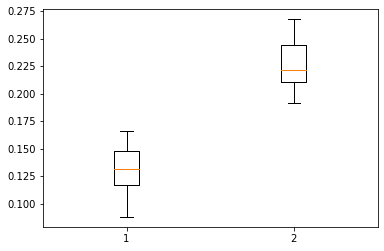

In [13]:
print(f"Bandwidth Constant:")
print(f"CV: {Ch_df.Ch_CV.median(): .4f}")
print(f"REG: {Ch_df.Ch_REG.median(): .4f}")

plt.boxplot([Ch_df.Ch_CV, Ch_df.Ch_REG])
plt.plot()

In [14]:
training_ratio_list = [0.01, 0.1, 0.50, 1.00]
Ch = Ch_df.Ch_REG.median()
Ch = round(Ch, 4)
print(f"Ch (Bandwidth Constant): {Ch}")

manager = Manager()
stats_dict = manager.dict(stats_dict)

Ch (Bandwidth Constant): 0.2217


In [15]:
# consistency_path = f"./【results】/consistency_KEM-{datetime.date.today().isoformat()}.csv"
consistency_path = f"./【results】/consistency_KEM-2023-11-02.csv"

# with open(consistency_path, 'w', newline = '', encoding='utf-8') as f:
#     csv_write = csv.writer(f)  
#     csv_write.writerow(["patient", "seed", "depth", "training_ratio", "kernel_size", "pi_rmse", "mu_rmse", "sigma_rmse"])

In [16]:
B = 1000
index = 3
stats_dict['index'] = index

In [46]:
sample_CT_path = stats_dict['lung_image_file_list'][index]
sample_CT_path
# sample_CT_array, origin, spacing, isflip = load_itk_image(sample_CT_path)  # sample_CT_array in (z, y, x) order

'/database/datasets/Classics/LUNA2016/IMAGES/1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975.mhd'

In [17]:
idx_increase = int(B / num_gpu)
i = gpu_name
idx_start = i * idx_increase
idx_end = (i + 1) * idx_increase

if i == num_gpu - 1:
    idx_end = B
print(f"GPU{gpu_name} with index list: [{idx_start}:{idx_end}]")

GPU0 with index list: [0:1000]


In [18]:
for seed in [406]:
    print(f"\n===========seed={seed}===========")
    stats_dict['seed'] = seed
    process_eval = Process(target=compute_rmse_4_consistency_new, 
                           args=(stats_dict, consistency_path,
                                 training_ratio_list, Ch, 3))
    process_eval.start()
    process_eval.join()


===========seed=406===========


2023-11-05 02:29:00.008213: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 02:29:00.564263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:35:00.0, compute capability: 8.0
2023-11-05 02:29:01.893336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5038 seconds
	centers: [0.99813104 0.5046934  0.10867383]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (21, 21, 21, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0301959
	 Current mu difference: 0.00283474
	 Current sigma difference: 0.000811112
From function(kem_a

In [19]:
exist_csv = pd.read_csv(consistency_path)
exist_csv.head()

,patient,seed,depth,training_ratio,kernel_size,pi_rmse,mu_rmse,sigma_rmse
0,patient_3,0,149,0.01,17,0.073972,0.041860,0.023292
1,patient_3,0,149,0.10,11,0.045679,0.022789,0.013797
2,patient_3,0,149,0.50,9,0.030180,0.016450,0.011490
3,patient_3,250,149,0.01,17,0.074334,0.041212,0.022914
4,patient_3,0,149,1.00,9,0.024604,0.015213,0.010861


In [20]:
failed_seed = []

for seed in range(idx_start, idx_end):
#     print(f"\n===========seed={seed}===========")
    data_index = exist_csv[exist_csv.seed == seed]
    if data_index.shape[0] == 4:
        continue
    failed_seed.append(seed)

print(failed_seed)

[0, 4, 302, 406, 418, 515, 532]


In [22]:
for seed in failed_seed:
    stats_dict['seed'] = seed
    process_eval = Process(target=compute_rmse_4_consistency_new, 
                           args=(stats_dict, consistency_path,
                                 training_ratio_list, Ch, "Failed"))
    process_eval.start()
    process_eval.join()

2023-11-04 03:11:37.987607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:11:38.541977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:11:39.658537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.6308 seconds
	centers: [0.9982704  0.5056153  0.10960178]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0311319
	 Current mu difference: 0.00311244
	 Current sigma difference: 0.0008427
From function(kem_alg

2023-11-04 03:16:52.688988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:16:53.194381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:16:54.306006: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5721 seconds
	centers: [0.9981956  0.5058855  0.10958279]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 

2023-11-04 03:22:07.660323: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:22:08.169944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:22:09.264889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5796 seconds
	centers: [0.9978587  0.50444084 0.10946815]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 

2023-11-04 03:27:22.217462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:27:22.728700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:27:23.848398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.563 seconds
	centers: [0.99813104 0.5046934  0.10867383]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.


Process Process-6:
Traceback (most recent call last):
  File "/root/miniconda3/envs/myconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/root/miniconda3/envs/myconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/KEM/KEM_simulation/simulation_auxiliary.py", line 510, in compute_rmse_4_consistency_new
    kem.kem_algorithm(max_steps=20, epsilon=1e-4, smooth_parameter=1e-20)
  File "/mnt/KEM/KEM_simulation/KEM_SIMU.py", line 87, in kem_algorithm
    assert tf.reduce_sum(tf.cast(self.denominator == 0, dtype=tf.float32)) == 0
AssertionError
2023-11-04 03:27:47.030659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5977 seconds
	centers: [0.9981861  0.5053361  0.10933904]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
+++ From m_step: add smooth_parameter to pi_estimate
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 

2023-11-04 03:33:02.283152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:33:02.792004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:33:03.910173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.6069 seconds
	centers: [0.9982509  0.5053628  0.10942154]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222205
From function(kem_algorithm): E step success.
From m_step: add smooth_parameter to sigma_estimate
	 Current pi difference: 0.0311031
	 Current mu difference: 0.00311001
	 Curre

2023-11-04 03:38:20.345918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 03:38:20.850128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:34:00.0, compute capability: 8.0
2023-11-04 03:38:22.183302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


From function(generate_mu_sigma_new_version)
	 mu_const: Class bone[0.5144]; Class lung[0.2344]
------------- Ratio 0.01 -------------
From function(__init__): Initialize mu via kmeans(with K=3)
From function(__init__): Randomly pick 1.0 positions for kmeans.
From function(__init__): KMeans(with K=3) success, with time: 0.5438 seconds
	centers: [0.99833184 0.5047496  0.10922497]
From function(__init__): Initialize parameters successfully.
	pik_estimate:(3, 149, 512, 512, 1)
	pi_estimate: (3, 149, 512, 512, 1)
	mu_estimate: (3, 149, 512, 512, 1)
	sigma_estimate: (3, 149, 512, 512, 1)
From function(__init__): Initialize kernel successfully.
	kernel: (19, 19, 19, 1, 1)
From function(kem_algorithm): Receive max_steps: 20.
########################## STEP 0 ##########################
	 Current pik difference: 0.222204
From function(kem_algorithm): E step success.
	 Current pi difference: 0.0311366
	 Current mu difference: 0.0031395
	 Current sigma difference: 0.000848107
From function(kem_al